# PII Data Exploration Notebook

## Introduction
Welcome to the PII Data Exploration Notebook! In this notebook, we will be exploring a dataset containing school essays that may contain personal identifiable information (PII). Our goal is to develop a system that can classify and mask any PII present in the essays.

As we are dealing with sensitive data, it is crucial to ensure the privacy and security of individuals. Therefore, we will focus on feature extraction of the tokens in order to create a more interpretable model. By understanding the characteristics and patterns of the PII tokens, we can develop effective strategies for classification and masking.

## Dataset Overview
The dataset consists of a collection of school essays, each accompanied by a set of labels indicating the presence of PII. The labels follow the BIO format, where "B" represents the beginning of a PII entity, "I" represents the continuation of a PII entity, and "O" represents non-PII tokens.

## Notebook Structure
This notebook is structured as follows:

1. Data Loading and Preprocessing: We will load the dataset and perform necessary preprocessing steps such as tokenization and label encoding.

2. Data Exploration: We will analyze the distribution of text lengths, class imbalance, positional occurrence of PII tags, label lengths, and word frequencies for each label. These analyses will provide insights into the characteristics of the dataset and help guide our feature extraction process.

3. Feature Extraction: Based on the findings from the data exploration, we will extract meaningful features from the tokens to enhance the interpretability of our model. This step is crucial for ensuring the privacy and security of individuals while maintaining the utility of the data.

4. Model Development: We will develop a classification model using the extracted features to identify PII tokens in the essays. The model will be evaluated using appropriate metrics to assess its performance.

5. PII Masking: Finally, we will apply a masking technique to replace the identified PII tokens with anonymized placeholders. This step is essential for protecting the privacy of individuals and ensuring compliance with data protection regulations.

## Conclusion
By conducting thorough data exploration and implementing effective feature extraction techniques, we aim to develop a robust PII classification and masking system for school essays. This notebook will serve as a comprehensive guide to our data exploration process and provide valuable insights for further analysis and model development.

Let's get started with the data exploration!


In [1]:
# import necesasry libraries
import json
import random
import itertools
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.graph_objects as go
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import gender_guesser.detector as gender
from ethnicseer import EthnicClassifier;



---

# Prepare data

---

In [2]:
file_path = "../data/train.json"

with open(file_path, "r") as file:
    data = json.load(file)
df = pd.DataFrame(data)
print(f"Number of samples: {len(df)}")
print(f"Columns: {[col for col in df.columns]}")
df.head()

Number of samples: 6807
Columns: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels']


,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [3]:
# The test data
file_path = "../data/test.json"
with open(file_path, "r") as file:
    data = json.load(file)
df = pd.DataFrame(data)
print(f"Number of samples: {len(df)}")
print(f"Columns: {[col for col in df.columns]}")
df.head()

Number of samples: 10
Columns: ['document', 'full_text', 'tokens', 'trailing_whitespace']


,document,full_text,tokens,trailing_whitespace
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal..."


In [6]:

print(df.iloc[0]['full_text'])

Design Thinking for innovation reflexion-Avril 2021-Nathalie Sylla

Challenge & selection

The tool I use to help all stakeholders finding their way through the complexity of a project is the  mind map.

What exactly is a mind map? According to the definition of Buzan T. and Buzan B. (1999, Dessine-moi  l'intelligence. Paris: Les Éditions d'Organisation.), the mind map (or heuristic diagram) is a graphic  representation technique that follows the natural functioning of the mind and allows the brain's  potential to be released. Cf Annex1

This tool has many advantages:

•  It is accessible to all and does not require significant material investment and can be done  quickly

•  It is scalable

•  It allows categorization and linking of information

•  It can be applied to any type of situation: notetaking, problem solving, analysis, creation of  new ideas

•  It is suitable for all people and is easy to learn

•  It is fun and encourages exchanges

•  It makes visible the dimension of pr

In [3]:
# print all length and all unique labels
lables_list = np.concatenate(df['labels'].values)
labels = sorted(list(set(lables_list)))
print(f"Number of unique labels: {len(labels)}")
print(f"Unique labels:")
for label in labels:
    print(f"  {label}")


# ignoring the BIO format
labels_not_bio = list(dict.fromkeys([label[2:] if label != "O" else 'O' for label in labels]))
print(f"\nNumber of unique labels (ignoring the BIO format): {len(labels_not_bio)}")


# Conversion variables
# id conversion
id2label = dict(enumerate(labels)) 
label2id = {v:k for k,v in id2label.items()}
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'pink', 'brown', 'black', 'gray', 'cyan', 'magenta', 'yellow']
label2color = {label: colors[i] for i, label in enumerate(labels)}
# other
num_labels = len(labels)
# BIO format to not BIO format label mapping
bio2notbio = {label: label[2:] if label != "O" else 'O' for label in labels}
notbio2bio = {label: [] for label in labels_not_bio}
for key, value in bio2notbio.items():
    notbio2bio[value].append(key)

Number of unique labels: 13
Unique labels:
  B-EMAIL
  B-ID_NUM
  B-NAME_STUDENT
  B-PHONE_NUM
  B-STREET_ADDRESS
  B-URL_PERSONAL
  B-USERNAME
  I-ID_NUM
  I-NAME_STUDENT
  I-PHONE_NUM
  I-STREET_ADDRESS
  I-URL_PERSONAL
  O

Number of unique labels (ignoring the BIO format): 8


Note: not all labels consist of the full BIO format - i.e. not utilizing the continuation prefix I

#### Prepare additional data for analysis

I.e. useful data when performing the data analysis.

In [6]:
# create dictionaries for data analysis
label_2_word_list = {label: [] for label in labels} # list of words for each label
label_2_word_lengths = {label: [] for label in labels} # list of word lengths for each label
label_2_norm_positions = {label: [] for label in labels} # list of normalized positions for each label
label_2_occurrences = {label: [] for label in labels} # number of occurrences for each label
label_2_context_before = {label: [] for label in labels} # context for each label
label_2_context_after = {label: [] for label in labels} # context for each label
b_labels = [label for label in labels if label[0] == "B"] # list of B- labels
label_2_Is_after_B = {label: [] for label in b_labels} # given a B-, how many I's follow

# iterate over the data
for i, row in tqdm(df.iterrows(), total=len(df)):
    n_tokens = len(row['tokens'])
    for label in labels:
        label_2_occurrences[label].append(0)
    # iterate over the tokens in a document
    for i_token, (token, label) in enumerate(zip(row['tokens'], row['labels'])):
        # store the token, length and normalized position
        label_2_word_list[label].append(token)
        label_2_word_lengths[label].append(len(token))
        label_2_norm_positions[label].append(i_token / n_tokens)
        label_2_occurrences[label][i] += 1
        # store the context, watch out for the limits
        context_before = row['tokens'][max(0, i_token-1)] if i_token > 0 else "None"
        context_after = row['tokens'][min(n_tokens-1, i_token+1)] if i_token < n_tokens-1 else "None"
        label_2_context_before[label].append(context_before)
        label_2_context_after[label].append(context_after)
        # store the number of I's after a B-
        if label[0] == "B":
            n_i = 0
            for j_token in range(i_token+1, n_tokens):
                if row['labels'][j_token] == f"I-{label[2:]}":
                    n_i += 1
                else:
                    break
            label_2_Is_after_B[label].append(n_i)

  0%|          | 0/6807 [00:00<?, ?it/s]

100%|██████████| 6807/6807 [00:19<00:00, 353.26it/s]


Note: each `label_2_...` variable consists of a dictionary, wherein each labels stores all its words, word lengths, normalized positions irrespective of documents.

#### Prepare reoccuring functions

In [109]:
def data2notbio(data_dict, bio2notbio):
    """
    Convert a dictionary of data from BIO format to not BIO format.

    Parameters
    ----------
    data_dict : dict
        Dictionary with keys as BIO format labels and values as lists of data.
    bio2notbio : dict
        Dictionary mapping BIO format labels to not BIO format labels.

    Returns
    -------
    dict
        Dictionary with keys as not BIO format labels and values as lists of data.
    """
    new_data = {val: [] for val in bio2notbio.values()}
    for key, value in data_dict.items():
        new_key = bio2notbio[key]
        new_data[new_key].extend(data_dict[key])
    return new_data


---

# General data overview

This section serves as an introduction to the data analysis.

---


## Document analysis

#### Distribution of document lengths

We explore the number of tokens within each document - i.e. each student essay.


Mean length: 733.44
Max length: 3298.00
Min length: 69.00


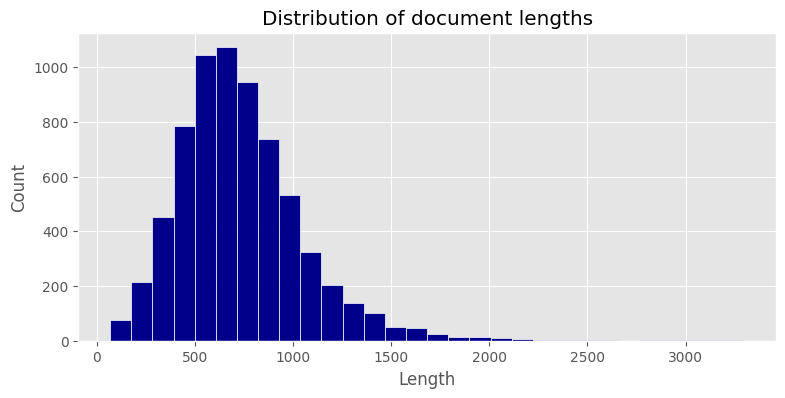

In [185]:
# Plot lengths
plt.figure(figsize=(9, 4))
lengths = df['tokens'].apply(len)

print(f"Mean length: {np.mean(lengths):.2f}")
print(f"Max length: {np.max(lengths):.2f}")
print(f"Min length: {np.min(lengths):.2f}")

# add bin space
plt.hist(lengths, bins=30, edgecolor='white', color='darkblue')
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of document lengths")
plt.show()

Note:
- Generally the textw follow a normal distribution, however with a right tail.
- Probably due to the nature of the texts being student texts with restrictions on their lengths.
- However they can vary quite alot, with a minimum of 69 and maximum of 3298.

In [175]:
# print average occurence per label in documents
avg_occurrences = {label: np.mean(label_2_occurrences[label]) for label in labels}
print("Average occurrences per label in documents:")
for label, avg_occurrence in avg_occurrences.items():
    print(f"  {label}: {avg_occurrence:.4f}")

Average occurrences per label in documents:
  B-EMAIL: 0.0057
  B-ID_NUM: 0.0115
  B-NAME_STUDENT: 0.2005
  B-PHONE_NUM: 0.0009
  B-STREET_ADDRESS: 0.0003
  B-URL_PERSONAL: 0.0162
  B-USERNAME: 0.0009
  I-ID_NUM: 0.0001
  I-NAME_STUDENT: 0.1610
  I-PHONE_NUM: 0.0022
  I-STREET_ADDRESS: 0.0029
  I-URL_PERSONAL: 0.0001
  O: 733.0386


Note: there is actually no PII tag which appears in every text, e.g. `B-NAME_STUDENT` is only there 20% of the time.

In [9]:
# print average occurence per label in documents
avg_occurrences = {label: np.mean(label_2_Is_after_B[label]) for label in b_labels}
print("Average occuring I's after a B per label in documents:")
for label, avg_occurrence in avg_occurrences.items():
    print(f"  {label}: {avg_occurrence:.4f}")

Average occuring I's after a B per label in documents:
  B-EMAIL: 0.0000
  B-ID_NUM: 0.0128
  B-NAME_STUDENT: 0.8029
  B-PHONE_NUM: 2.5000
  B-STREET_ADDRESS: 10.0000
  B-URL_PERSONAL: 0.0091
  B-USERNAME: 0.0000


Note: we see that `PHONE_NUM` and `STREET_ADDRESS` usually consist of a lot of I's

In [186]:
# print number of documents with no labels
doc_occurrences = pd.DataFrame(label_2_occurrences)
# drop O
doc_occurrences = doc_occurrences.drop(columns=["O"])
# sum in direction of axis 1
print(f"Number of documents with no labels: {len(doc_occurrences[doc_occurrences.sum(axis=1) == 0])} out of {len(df)}")

Number of documents with no labels: 5862 out of 6807


Note: mystery solved, the majority of documents have no PII tags at all.

---

## Label imbalance

The dataset consists of 13 unique labels where each document can contain the same label multiple times. Therefor, one can expect the distribution of labels to be uneven.

In [111]:
def plot_label_occurence(unique_labels, label_counts, title="Label Occurence"):
    """
    Plot the occurence of labels in the dataset.

    Parameters
    ----------
    unique_labels : list
        List of unique labels.
    label_counts : list
        List of counts for each label.
    title : str, optional
        Title of the plot, by default "Label Occurence".
    """
    # plot a histogram of label occurences, labels on y-axis
    plt.figure(figsize=(6, 5))
    plt.barh(unique_labels, label_counts, color='brown')   
    plt.xscale("log")
    for i, count in enumerate(label_counts):
        plt.text(count, i, f" {count} ", va='center')
    plt.xlabel('Log Counts')
    plt.ylabel('Labels')
    plt.title(title)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

#### Label occurence across documents

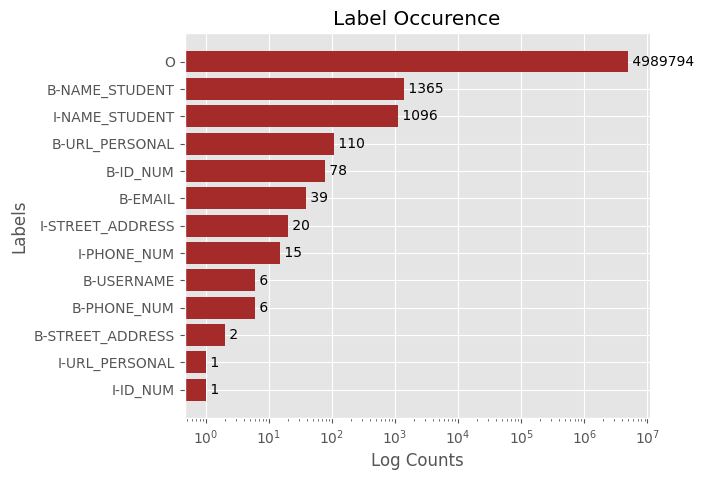

In [112]:
# Get useful lists
lables_list = np.concatenate(df['labels'].values)
unique_labels, label_counts = np.unique(lables_list, return_counts=True)
# sort
sorted_indices = np.argsort(label_counts)
unique_labels = unique_labels[sorted_indices]
label_counts = label_counts[sorted_indices]

plot_label_occurence(unique_labels, label_counts, title="Label Occurence")

Note: 
- The data is heavily skewed with `Name` being the most occurring label after `O`.
- Some labels are highly unrepresented, e.g. `I-URL_PERSONAL` and `I-ID_NUM`.
- `STREET_ADDRESS` and `PHONE_NUM` have more of the `I` than the `B`, probably because they consist of multiple components.


#### Label occurence - removing the BIO format

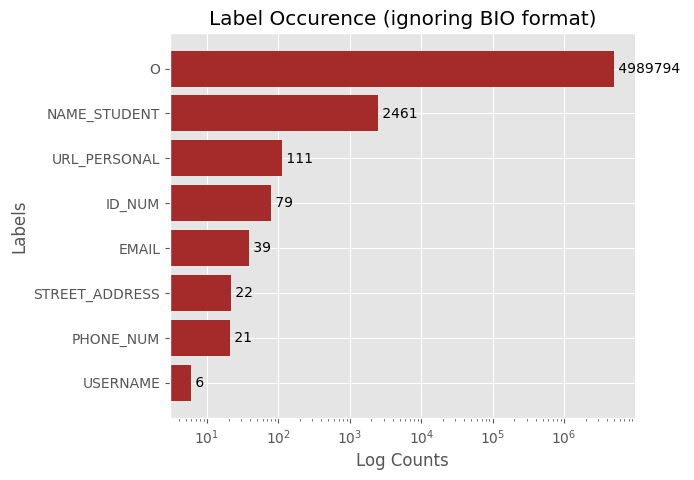

In [113]:
new_labels_list = [label[2:] if label != 'O' else label for label in lables_list]
unique_labels, label_counts = np.unique(new_labels_list, return_counts=True)
# sort
sorted_indices = np.argsort(label_counts)
unique_labels = unique_labels[sorted_indices]
label_counts = label_counts[sorted_indices]
plot_label_occurence(unique_labels, label_counts, title="Label Occurence (ignoring BIO format)")

Note:
- Even though the `I` for both `URL_PERSONAL` and `ID_NUM` didn't occur very often, then their concatenated label is among top 3 and 4.
- Very low counts on `USERNAME`

#### Sample from each label

In [347]:
data = data2notbio(label_2_word_list, bio2notbio)
for key, value in data.items():
    print(key)
    # sample 3
    n_samples = 2
    while n_samples > 0:
        try: 
            samples = random.sample(value, n_samples)
            n_samples = 0
        except:
            n_samples -= 1
    for sample in samples:
        print(f"    {sample}")

EMAIL
    john03@yahoo.com
    pauljohnson@hotmail.com
ID_NUM
    188408534931
    143860010348
NAME_STUDENT
    Luc
    Roberto
PHONE_NUM
    410.526.1667
    820)913
STREET_ADDRESS
    Erika
    Apt
URL_PERSONAL
    http://www.barry.com/main/list/postshomepage.html
    https://www.facebook.com/pamela23
USERNAME
    meyermichelle
    fdixon
O
    our
    methods


Note: there are some useful expression for some of the labels.


---

# More in-depth analysis

This analysis will go more in-depth for each label, in order to get a better understanding of how they behave in the documents.

Specifically we'll investigate:
- Positional occurence

---


## Positional occurence

As we have already seen, most documents consist of more than 500 plus tokens. 

However, there might be some positional patterns as to when each label occurs within each student text.

#### PII position in documents

In [114]:
def plot_positional_occurence(pos, title):
    """
    Plot the distribution of the positions of the tokens in the documents.

    Parameters
    ----------
    pos : list
        List of positions of the tokens in the documents.
    title : str
        Title of the plot.
    """
    # Plot lengths
    plt.figure(figsize=(9, 3))
    plt.hist(pos, bins=30, edgecolor='white', color='mediumslateblue')
    plt.xlabel("Position")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

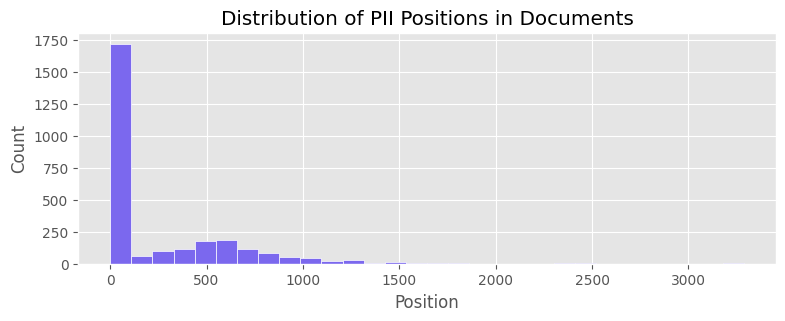

In [115]:
# Positions of PII
pos = np.concatenate([[i for i, ele in enumerate(entry) if ele != 'O'] for entry in df['labels']])
plot_positional_occurence(pos, "Distribution of PII Positions in Documents")

Notes:
- Generally the PII tags are at the start of the text.
- After that, it seems like a normal distribution, similar to the distribution of token counts.

#### Normalized PII tag position in documents

Since the documents vary in length, all positional occurences are dependent on the length of the documents - except the start positions. 

Therefore we explore the positional occurence normalized by document length.

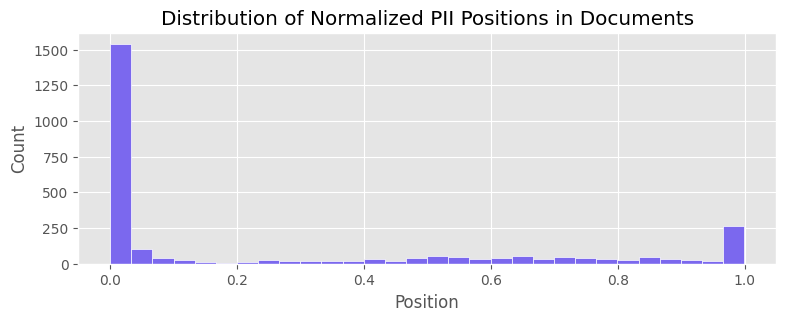

In [116]:
percentage_pos = np.concatenate([[i / len(entry)  for i, ele in enumerate(entry) if ele != 'O'] for entry in df['labels']])
plot_positional_occurence(percentage_pos, "Distribution of Normalized PII Positions in Documents")

Note:
- As expected, the positional occurence in percentage indicates that the labels mostly occurrs at the start or end of each document.
    - Probably due to the formalities within a student text

#### Label position within documents

In [141]:
def plot_label_histograms(data, title, xlabel, O=False):
    fig, axs = plt.subplots(2, 4, figsize=(20, 8))
    axs = axs.flatten()
    for i, label in enumerate(labels_not_bio): # iterate to maintain order
        # if O is defined as a string
        if label == 'O' and isinstance(O, str):
                axs[i].axis('off')  
                axs[i].set_title(O)
        else:
            for bio_label in notbio2bio[label]:
                if len(data[bio_label]) > 1:
                    #sns.kdeplot(label_2_norm_positions[bio_label], label=bio_label, ax=axs[i], fill=True, warn_singular=False)
                    sns.histplot(data[bio_label], label=bio_label, ax=axs[i], kde=False)
            axs[i].legend()
            axs[i].set_title(label)
            axs[i].set_xlabel(xlabel)
            axs[i].set_ylabel("Density")  

    fig.suptitle(title + '\n', fontsize=24)
    plt.tight_layout()
    plt.show()

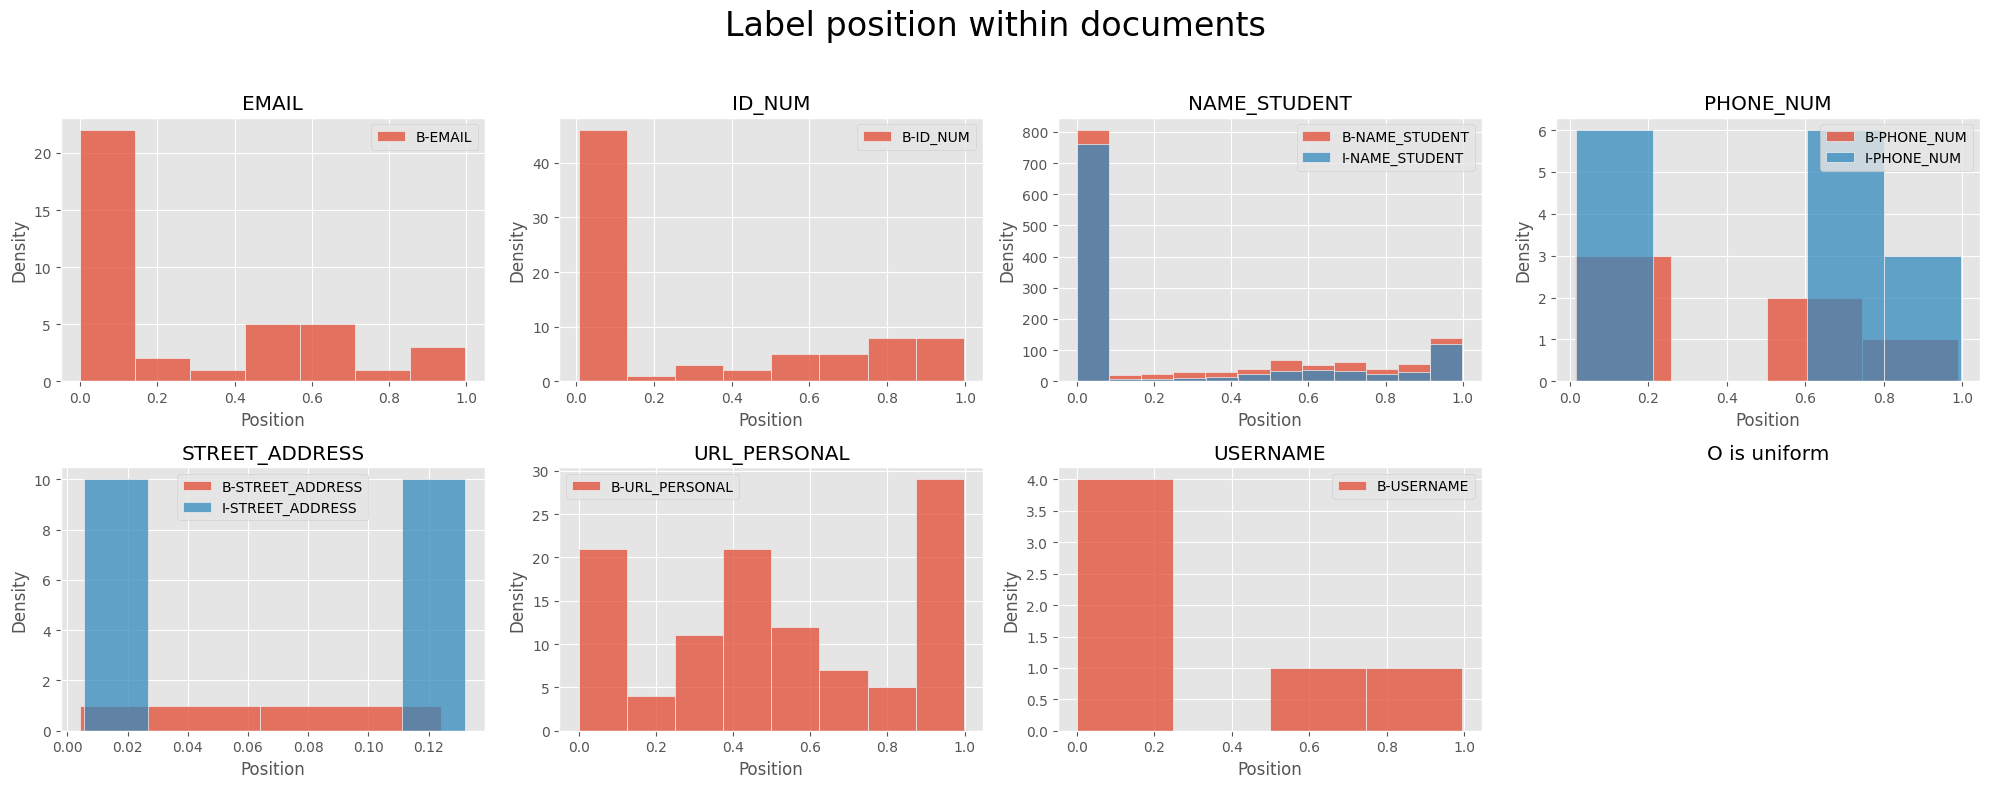

In [142]:
plot_label_histograms(label_2_norm_positions, 'Label position within documents', "Position", O="O is uniform")

Note:
- In general the data seems to have a tendency for two modes at the start and end of texts - however favoring the start.
    - except `URL_PERSONAL` which also has a mode in the middle.


#### Label position in documents excluding the BIO format

In [147]:
def plot_label_boxplotdata(data, title, ylabel):
    # boxplots
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=data)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

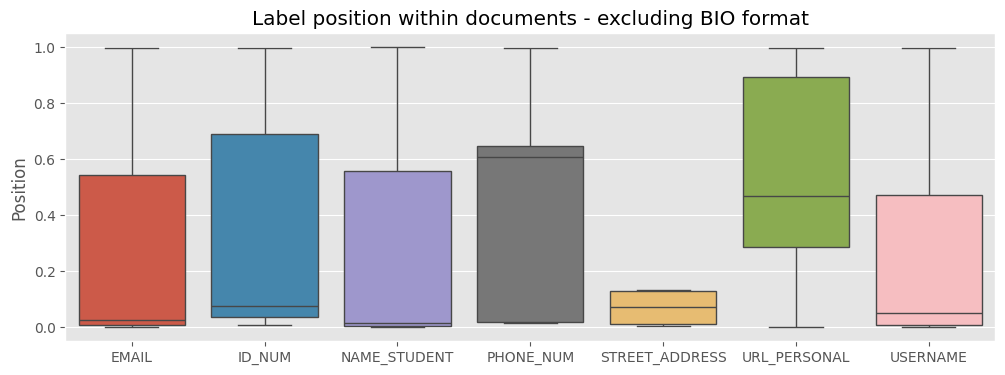

In [148]:
data = data2notbio(label_2_norm_positions, bio2notbio)
# but ignore 'O'
data.pop('O')

plot_label_boxplotdata(data, "Label position within documents - excluding BIO format", "Position")

Note:
- In general there is a tendency for the start and the middle of documents.
- However `PHONE_NUMBER` tends more towards in the middle.
- `STREET_ADDRESS` is in the start without much variation.
- And `URL_PERSONAL` favors the middle and the end.

All these tendencies are somewhat hard to explain but can provide meaningful insights.

---

## Label lengths


Some useful insight could be the general token length for each label - i.e. counting number of characters.

Especially the label `ID_NUM`, since such PII usually follows some strict patterns.


#### Label lengths in documents

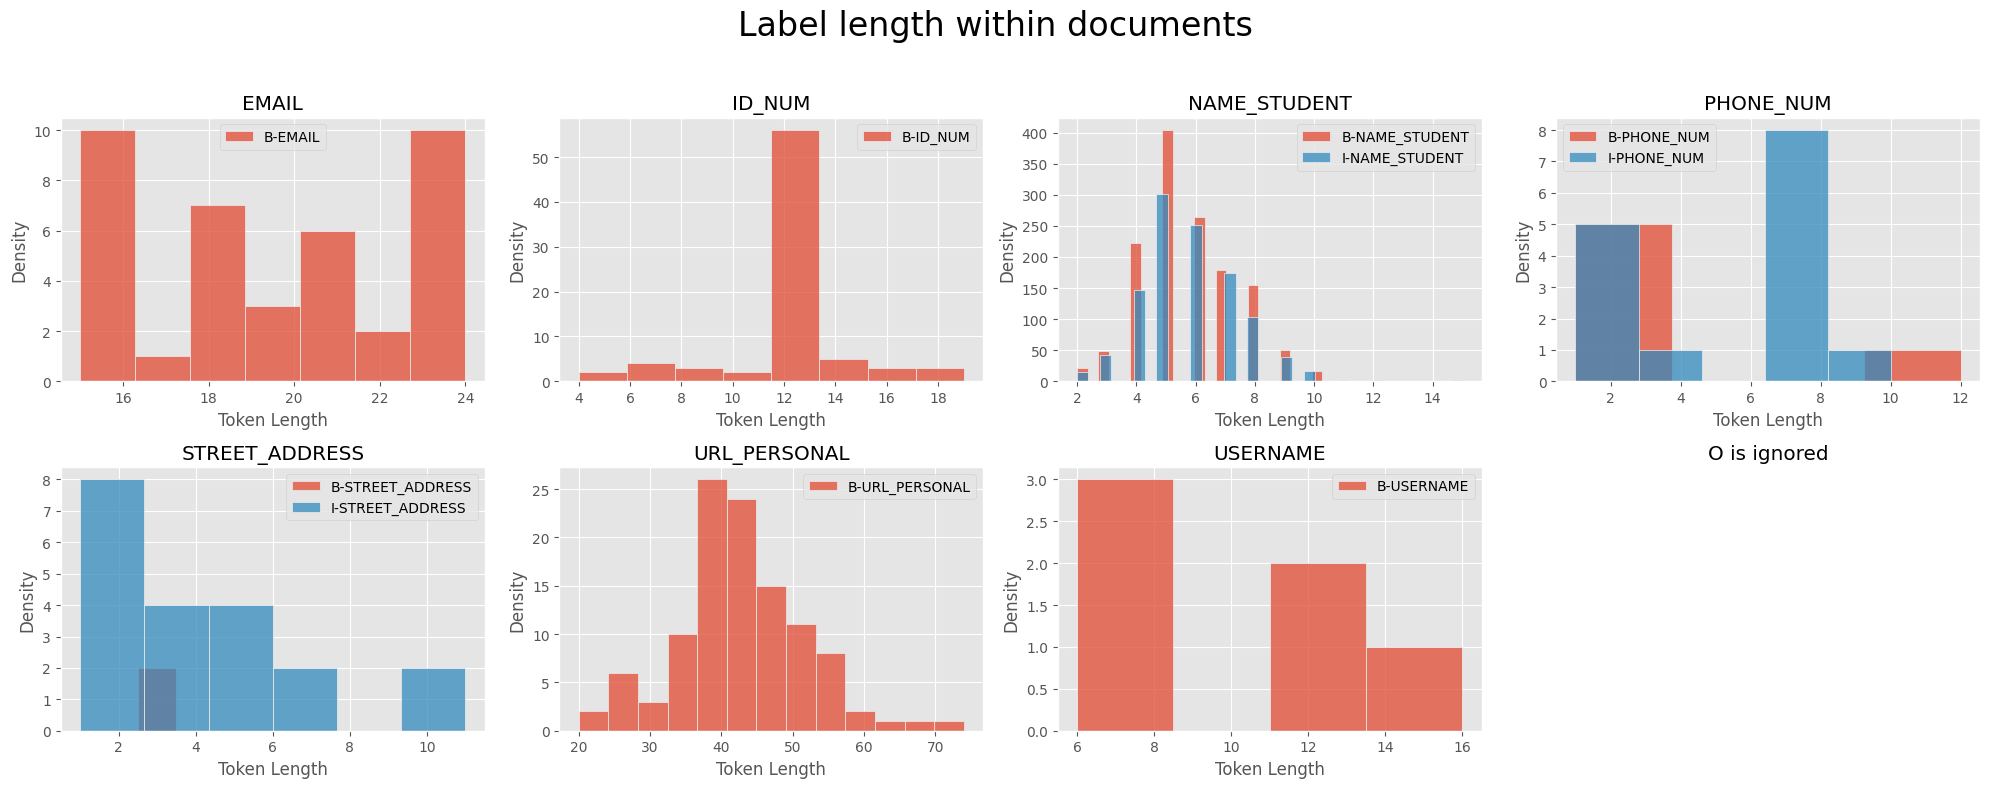

In [167]:
plot_label_histograms(label_2_word_lengths, 'Label length within documents', "Token Length", O="O is ignored")

Note:
- There is a clear difference in the distributions of each label.
- Both `B` and `I` for `NAME_STUDENT` are almost identical.
    - but for the `PHONE_NUM` there is a difference, probably due to phone number prefixes.
- `ID_NUM` seems to favor a length of 12 with few outliers, which might prove useful.

#### Label lengths in documents excluding the BIO format

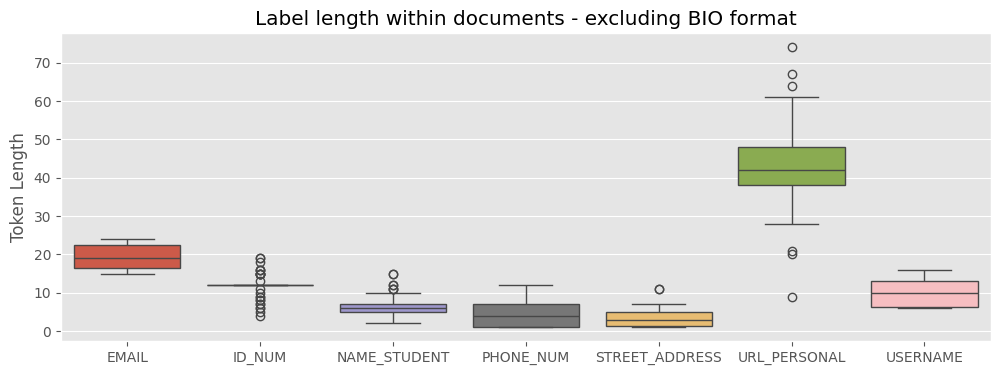

In [166]:
data = data2notbio(label_2_word_lengths, bio2notbio)
# but ignore 'O'
data.pop('O')
plot_label_boxplotdata(data, "Label length within documents - excluding BIO format", "Token Length")

Note:
- By joining each interclass BIO, the differences become even more apparent.
- Especially how `ID_NUM` seems very fixed on 12 with little variance.
- And that `EMAIL` and `URL_PERSONAL` are generally longer.

---

## Co-Occurence


Another interesting insight is how each label co-occurs with another across each document.

This indicates some form of correlation.


In [273]:
def plot_matrix(cm, classes,
                title='',
                cmap=plt.cm.Blues, figsize=(8, 8),
                xlabel='Predicted label', ylabel='True label'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # normalize cm by the diagonal values
    # get diagonal
    diag = cm.diagonal()
    # divide each column by the diagonal
    cm = cm / diag[:, None]
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # set fig size
    plt.figure(figsize=figsize)
    plt.grid(False)
    # cm is of shape (n_classes, n_classes), e.g. [[1, 0], [0, 1]]
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title+", normalized by diagonal")
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = 0.5#cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    


#### Co-Occurence Matrix

Can indicate how much one label occurs with another when it's present.

In [274]:
tf_doc_occurrences = (doc_occurrences > 0) * 1
# keep only B- 
current_labels = [label for label in labels if label.startswith('B-')]
tf_doc_occurrences = tf_doc_occurrences[current_labels]
co_occurrences = tf_doc_occurrences.T @ tf_doc_occurrences

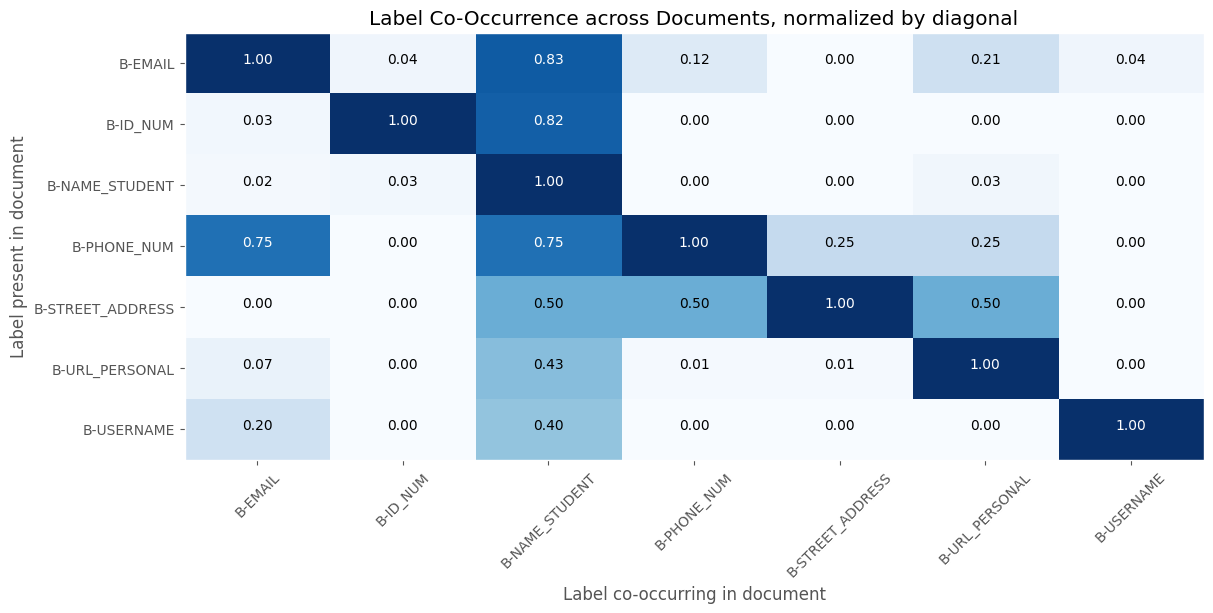

In [275]:
# plot as a confusion matrix
plot_matrix(co_occurrences.values, current_labels, title='Label Co-Occurrence across Documents', figsize=(12, 6),
            ylabel='Label present in document', xlabel='Label co-occurring in document')

Note:
- In order to understand the plot, take e.g. row `B-EMAIL`
    - If `B-EMAIL` occurs within a document, the plot indicates that 83% of the time `B-NAME_STUDENT` is also present. 
- Thus in general, the highly colored `B-NAME_STUDENT` column indicates that it co-occurs alot when the other variables are present.
    - i.e. we rarely see `B-EMAIL` without also seeing  `B-NAME_STUDENT`
- We also see that when `B-PHONE_NUM` is present, then `B-EMAIL` is often co-occurs too.


#### Co-Occurence Graph

Another way of visualizing this relationship with a graph - which is also more visually appealing.

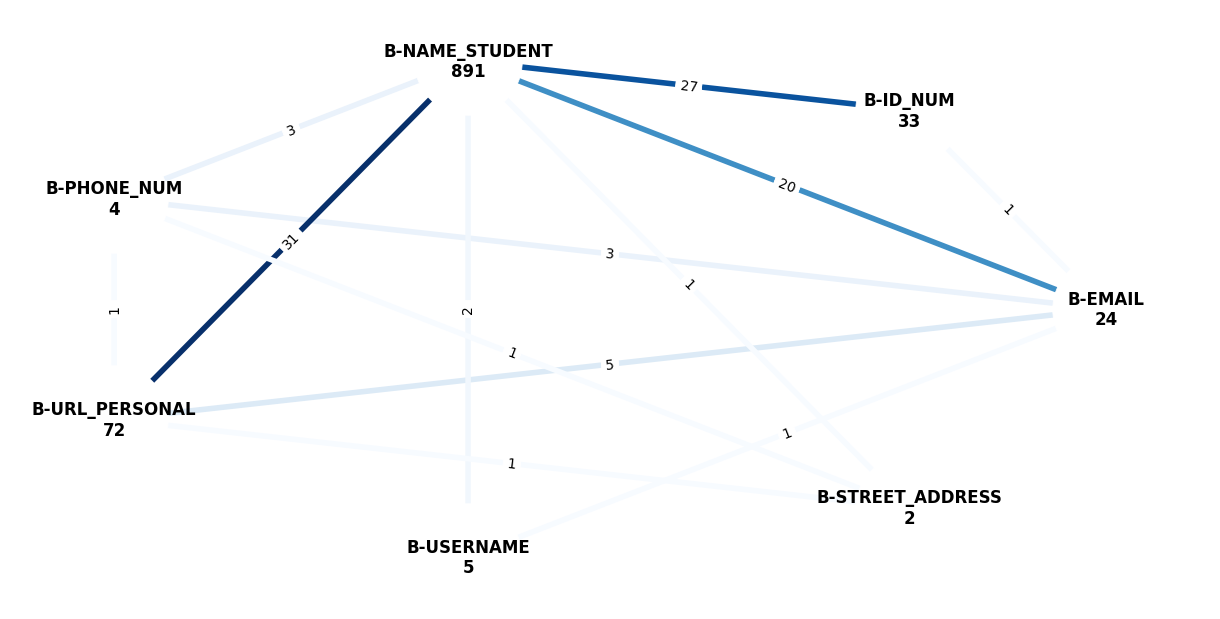

In [320]:
import networkx as nx
# Create a graph
G = nx.Graph()

# Add nodes and edges based on the co-occurrence matrix
n = len(co_occurrences)
edge_labels = {}
for i in range(n):
    for j in range(n):
        # ignore self-connections
        if i != j:
            if co_occurrences.values[i][j] > 0:
                G.add_edge(i, j, weight=co_occurrences.values[i][j], label=f"{co_occurrences.values[i][j]}")
                edge_labels[(i, j)] = co_occurrences.values[i][j]
# Add nodes with labels
node2label = {i: label + f"\n{co_occurrences.values[i][i]}" for i, label in enumerate(current_labels)}
# set ffig size
plt.figure(figsize=(12, 6))
#pos = nx.spring_layout(G)  # positions for all nodes
pos = nx.circular_layout(G)
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw(G, pos, 
        arrows=True, width=4, edge_color=weights, edge_cmap=plt.cm.Blues,
        with_labels=True, labels=node2label,
        node_color='white', node_size=6000, font_size=12, font_weight='bold')
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='black'
)
plt.show()

Note:
- This shows the relationships between the labels more clearly.
- Specifically, we see that `B-NAME_STUDENT` often co-occurs when the labels `B-URL_PERSONAL`, `B-ID_NUM` are `B-EMAIL` are present in a document
- That `B-NAME_STUDENT` most often occurs by itself.
- And the low representation of the other labels.

The insights from both visualizations indicate some important possibilities:
- `B-NAME_STUDENT` is the main component that is inter-connected with all the other labels.
- Furthermore, say e.g. `B-EMAIL` is easy to find by @, then this can contribute to finding `B-NAME_STUDENT` due to their co-occurence and vice-versa.

To sum up, we see that the `B-NAME_STUDENT` is very correlated with alot of the features, signifying its hierarchical importance. I.e. by first classifying a name, it could potentially contribute to classifying the rest of the labels

---

## Label similarities

Another insight could be some similarity measures between the tokens themselves for each label.

To achieve this, we can utilize character n-grams for each token together with TF-IDF to get a vector representation, then we can apply PCA to visualize the results.

In [401]:
# concatenate all tokens
all_tokens = []
all_token_labels = []
for label in labels:
    # subsample 100 from each label - if possible
    to_add = label_2_word_list[label][:100]
    all_tokens.extend(to_add)
    all_token_labels.extend([label] * len(to_add))
    #all_tokens.extend(label_2_word_list[label])

In [402]:
# Using character n-grams from length 2 to 5
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 8))
X = vectorizer.fit_transform(all_tokens)

In [403]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X.toarray())

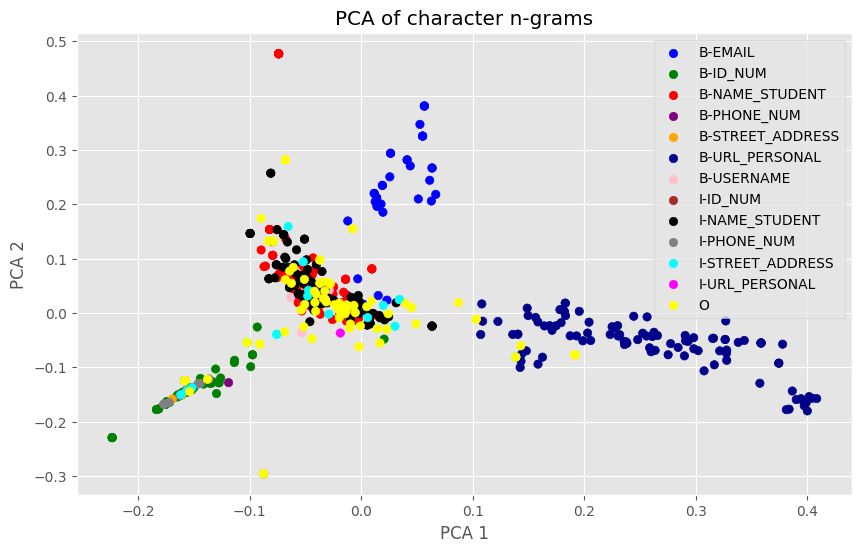

In [408]:
# plot pca
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[label2color[label] for label in all_token_labels])#, alpha=0.5)
# add a legend
for label, color in label2color.items():
    plt.scatter([], [], c=color, label=label)
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of character n-grams")
plt.show()

Note: 
- We see that a lot of the points are mixed in the middle and inseparable.
- However, `B-ID_NUM`, `B-EMAIL` and `B-URL_PERSONAL` how some separability, indicating they have some unique n-grams.
    - Probably due to some of their formatting.

In [409]:
# let's look at 3 examples from each of B-ID_NUM, B-EMAIL and B-URL_PERSONAL
n_samples = 3
for label in ["B-ID_NUM", "B-EMAIL", "B-URL_PERSONAL"]:
    print(f"Examples for label: {label}")
    # using label_2_word_list
    value = label_2_word_list[label]
    # get 3 examples
    samples = random.sample(value, n_samples)
    for sample in samples:
        print(f"    {sample}")


Examples for label: B-ID_NUM
    943063077874
    143860010348
    789323889085
Examples for label: B-EMAIL
    johnsondavid@hotmail.com
    kennethevans@hotmail.com
    djones@gmail.com
Examples for label: B-URL_PERSONAL
    http://www.barry.com/main/list/postshomepage.html
    https://www.linkedin.com/in/mmartinez
    https://soto.com/listregister.asp


Note:
- We clearly see their unique nature, i.e. 
    - `B-ID_NUM`: 12 numbers
    - `B-EMAIL`: the @ and domain
    - `B-URL_PERSONAL`: the http's

This insight is useful for regex models.

---

## Word frequencies

Let's look at the most populare words and tokens for each label.

Note that the word cloud generator does its own form of tokenization.


In [413]:
def plot_word_cloud(data, title):
    fig, axs = plt.subplots(3, 4, figsize=(12, 6))
    axs = axs.flatten()
    i=0
    for nb_label in labels_not_bio[:-1]:
        for label in notbio2bio[nb_label]:
            try: 
                #if len(label_2_word_list[label]) <= 1:
                #    continue
                wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(data[label]))
                axs[i].imshow(wordcloud)
            except:
                # continue
                pass

            axs[i].axis('off')
            axs[i].set_title(label)
            i+=1
    fig.suptitle(title + '\n', fontsize=20)
    plt.tight_layout()
    plt.show()

#### Word cloud on each label

Each word is displayed wrt. its frequency.

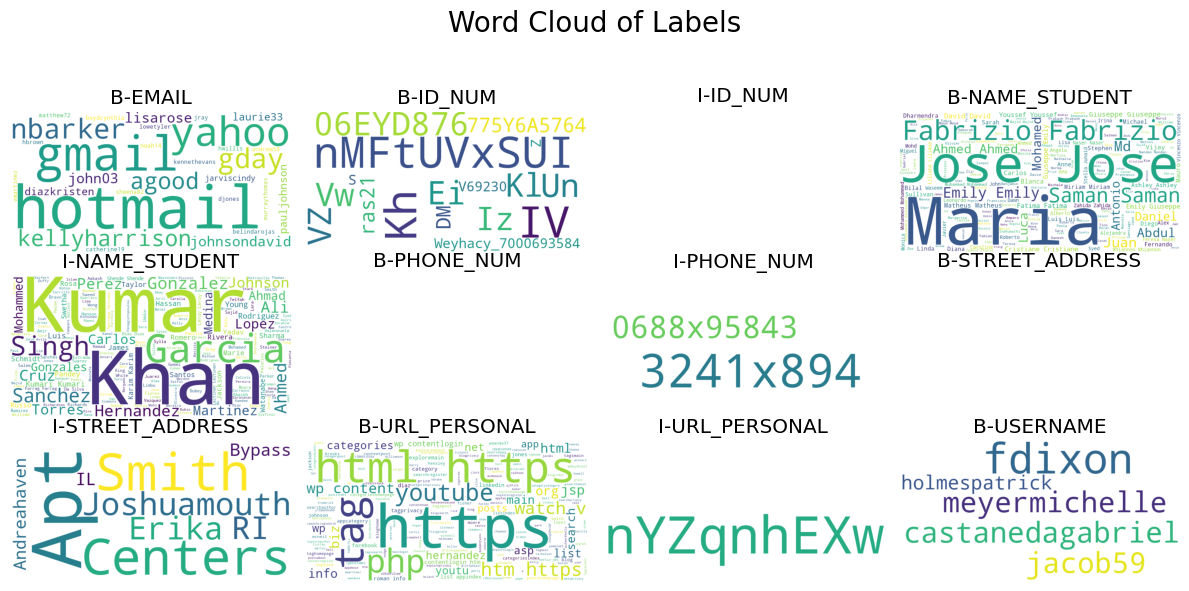

In [429]:
plot_word_cloud(label_2_word_list, "Word Cloud of Labels")

Note: 
- There are some general tendencies within each label that might prove useful.
    - E.g. for emails, phone numbers and personal urls.


### Word cloud on tokens before a label

The context in which a label appears can have some significance.

Notice that the `None` string indicates that no token was found before/after a label. 

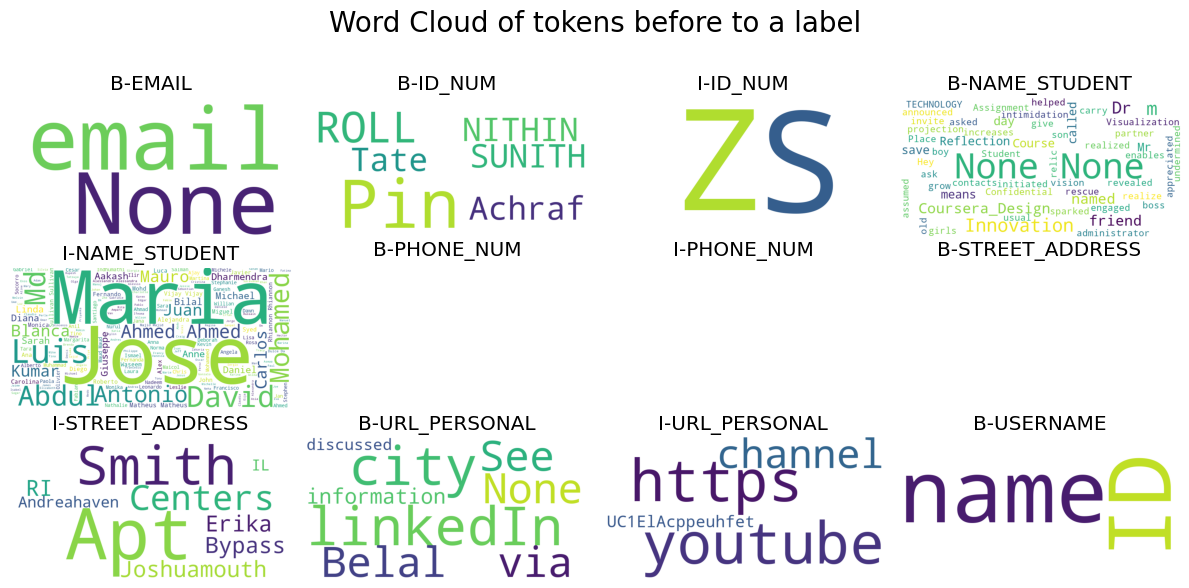

In [435]:
plot_word_cloud(label_2_context_before, "Word Cloud of tokens before a label")

Note:
- The string "None" often appears before `B-EMAIL` and `B-NAME_STUDENT`, indicating that the label is often at the start of the document.
- Furthermore, the words before `B-EMAIL` is mostly "email", and for `B-USERNAME` it is "name" and "ID"

These insights are useful for modelling.

One question arises: why are a lot of the word clouds just empty?

In [445]:
# exampels, focus on B
print(f"B-PHONE_NUM: {label_2_context_before['B-PHONE_NUM'][:3]}")
print(f"B-STREET_ADDRESS: {label_2_context_before['B-STREET_ADDRESS'][:3]}")

B-PHONE_NUM: [' ', ':', ':']
B-STREET_ADDRESS: [' ', '-']


Note: this comes to show that is it not really empty, but contains spaces and symbols - which can be useful.

### Word cloud on tokens after a label

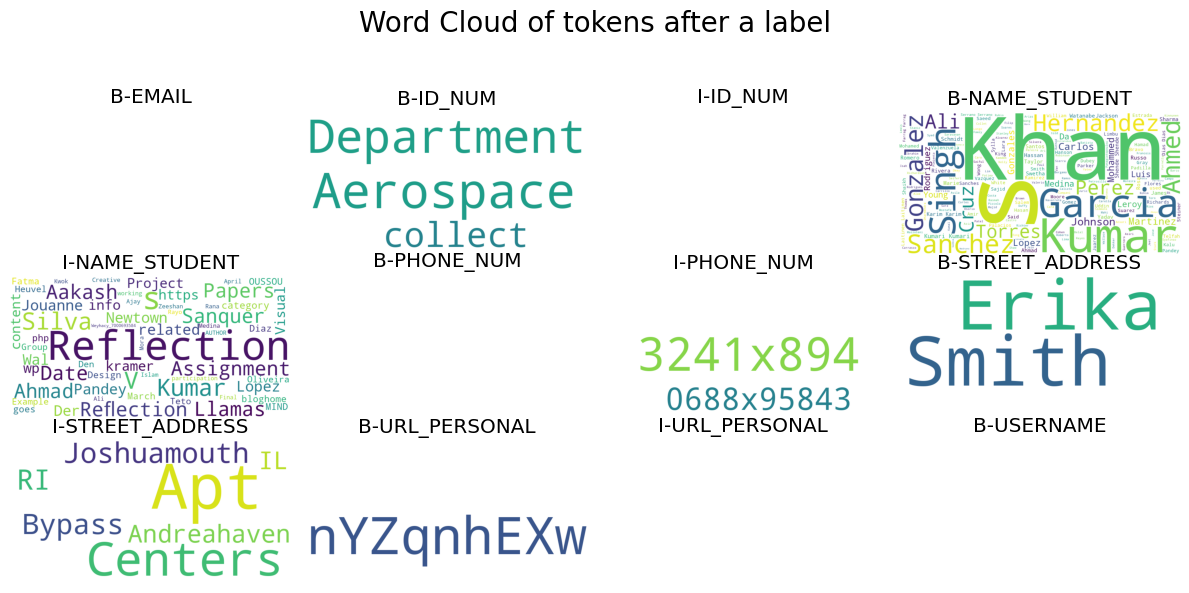

In [434]:
plot_word_cloud(label_2_context_after, "Word Cloud of tokens after a label")

Note: not much to note, however, a lot more empty word clouds, 

Let's investigate the empty word clouds:

In [446]:
# examples, focus on I
print(f"B-EMAIL: {label_2_context_after['B-EMAIL'][:3]}")
print(f"I-ID_NUM: {label_2_context_after['I-ID_NUM'][:3]}")
print(f"I-URL_PERSONAL: {label_2_context_after['B-URL_PERSONAL'][:3]}")
print(f"B-USERNAME: {label_2_context_after['B-USERNAME'][:3]}")

B-EMAIL: [' ', '\n\n', ',']
I-ID_NUM: ['\n\n']
I-URL_PERSONAL: ['\n\n', '     ', '    ']
B-USERNAME: ['but', '|', '|']


Note: the same case as we saw before, but with line breaks as well.

---

## Label specific analysis

Let's look at each label more in depth by considering some of its possible characteristics.


### NAME_STUDENT

In [448]:
# list of all the names
names = label_2_word_list['B-NAME_STUDENT'] + label_2_word_list['I-NAME_STUDENT']

#### Gender prediction

In [449]:
gender_detector = gender.Detector()
genders = [gender_detector.get_gender(name) for name in names]
uniques, counts = np.unique(genders, return_counts=True)

C:\Users\adj\AppData\Local\Temp\ipykernel_37836\3444565261.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(uniques, rotation=45);


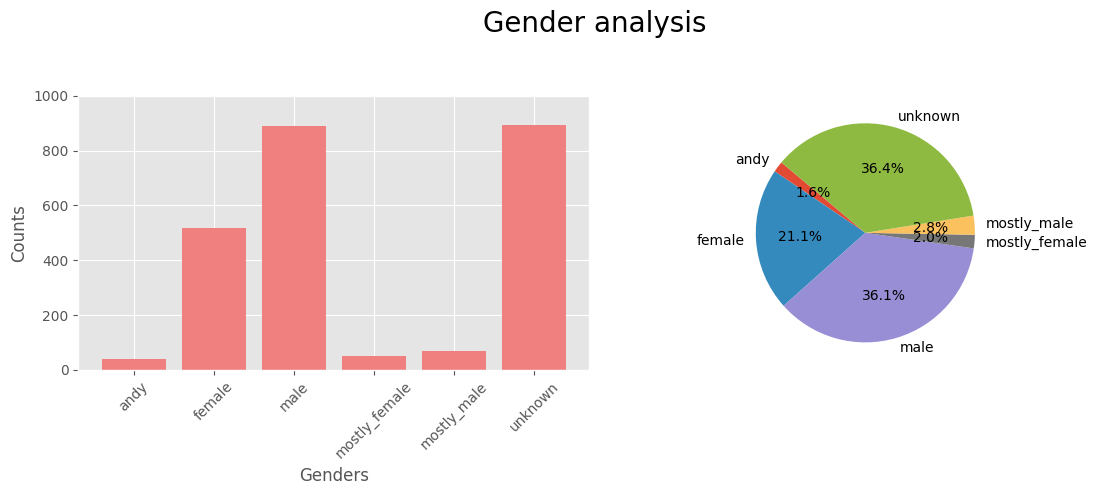

In [475]:
# two plots, bar and pie
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# bar plot
axs[0].bar(uniques, counts, color="lightcoral")
axs[0].set_yticks(axs[0].get_yticks().tolist())
axs[0].set_xticklabels(uniques, rotation=45);
axs[0].set_xlabel("Genders")
axs[0].set_ylabel("Counts")

# pie plot
axs[1].pie(counts, labels=uniques, autopct='%1.1f%%', startangle=140)
fig.suptitle("Gender analysis" + '\n', fontsize=20)
plt.tight_layout()
plt.show()

Note: in general it seems to be biased towards male, however there are a lot of unknowns.

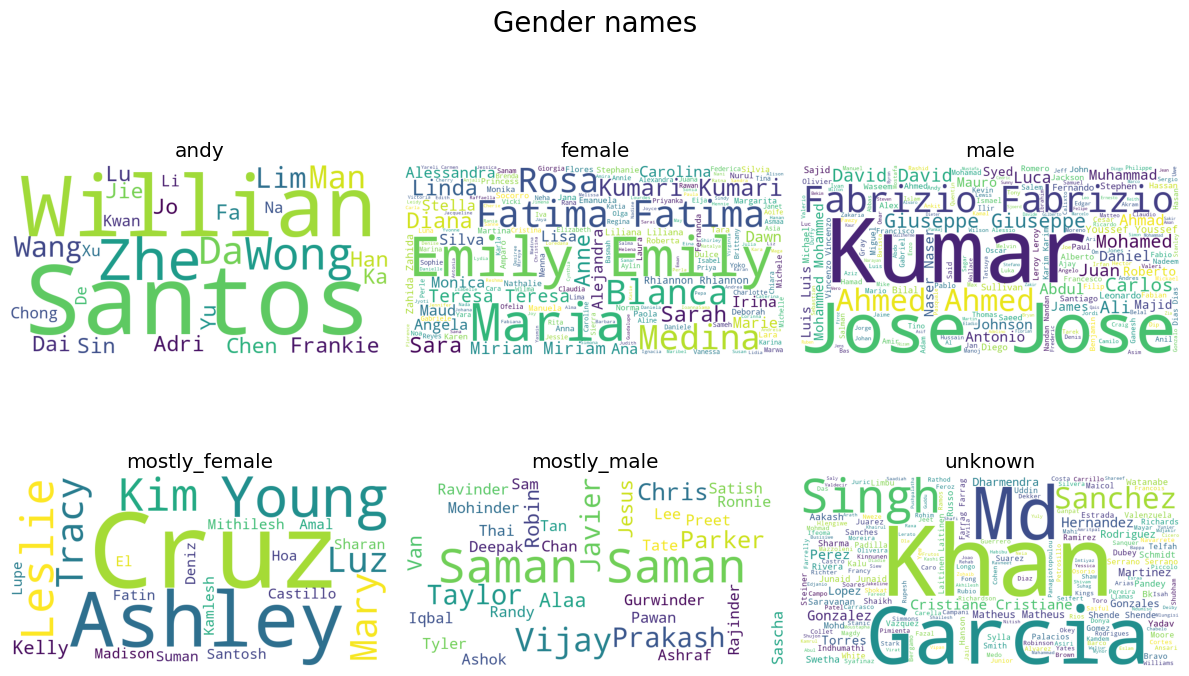

In [458]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# NOTE: there are only 6 shown
axs = axs.flatten()
dropped = 0
for i, _gender in enumerate(uniques):
    axs[i].axis('off')
    names_list = [name for (name, gender) in zip(names, genders) if gender == _gender]
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(names_list))
    axs[i].imshow(wordcloud)
    axs[i].set_title(_gender)
fig.suptitle("Gender names", fontsize=20)
plt.tight_layout()
plt.show()

Note: even though the texts are in english, there seems to be names of multitple ethnic backgrounds.

#### Ethnicity prediction

In [460]:
ec = EthnicClassifier.load_pretrained_model();

In [493]:
nationalities = ec.classify_names(names)
code_to_nationality = {
    'chi': 'Chinese',
    'eng': 'English',
    'frn': 'French',
    'ger': 'German',
    'ind': 'Indian',
    'ita': 'Italian',
    'jap': 'Japanese',
    'mea': 'Middle-Eastern',
    'rus': 'Russian',
    'spa': 'Spanish',
    'vie': 'Vietnamese',
    'kor': 'Korean'
}
print(len(code_to_nationality))
new_nationalities = [code_to_nationality[nationality] for nationality in nationalities]
uniques, counts = np.unique(new_nationalities, return_counts=True)


12


C:\Users\adj\AppData\Local\Temp\ipykernel_37836\2088754048.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(uniques, rotation=45);


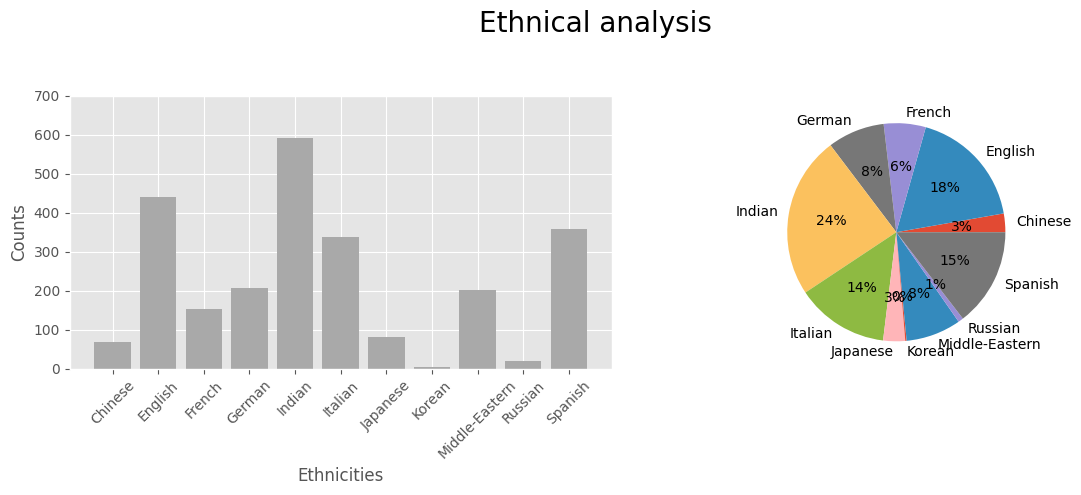

In [498]:
# two plots, bar and pie
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# bar plot
axs[0].bar(uniques, counts, color="darkgrey")
axs[0].set_yticks(axs[0].get_yticks().tolist())
axs[0].set_xticklabels(uniques, rotation=45);
axs[0].set_xlabel("Ethnicities")
axs[0].set_ylabel("Counts")

# pie plot
axs[1].pie(counts, labels=uniques, autopct='%1.0f%%', startangle=0)
fig.suptitle("Ethnical analysis" + '\n', fontsize=20)
plt.tight_layout()
plt.show()

Note:
- We see that most are English, Indian, Italian and Spanish - however quite evenly spread nonetheless.

### EMAIL

Most emails consist of @ follow by a domain.

In [489]:
data = data2notbio(label_2_word_list, bio2notbio)
# extract domain
domains = [email.split("@")[-1] for email in data['EMAIL']]
len(domains)
uniques, counts = np.unique(domains, return_counts=True)

C:\Users\adj\AppData\Local\Temp\ipykernel_37836\120355424.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(uniques, rotation=45);


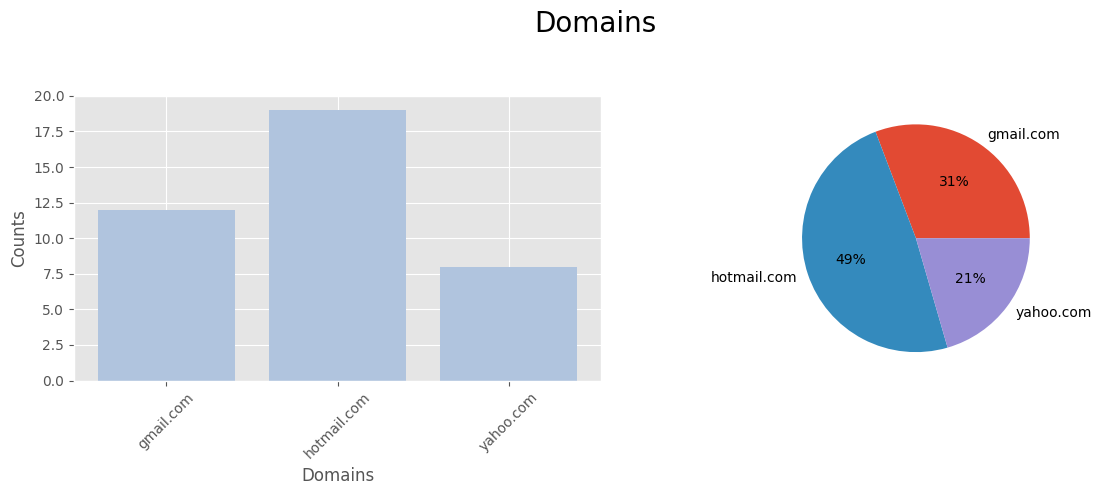

In [490]:
# two plots, bar and pie
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# bar plot
axs[0].bar(uniques, counts, color="lightsteelblue")
axs[0].set_yticks(axs[0].get_yticks().tolist())
axs[0].set_xticklabels(uniques, rotation=45);
axs[0].set_xlabel("Domains")
axs[0].set_ylabel("Counts")

# pie plot
axs[1].pie(counts, labels=uniques, autopct='%1.0f%%', startangle=0)
fig.suptitle("Domains" + '\n', fontsize=20)
plt.tight_layout()
plt.show()

Note: classifying emails seems trivial.

In [491]:
# do all contain @?
_not = [e for e in uniques if "@" not in e]
print(len(_not))
_not

3


['gmail.com', 'hotmail.com', 'yahoo.com']

Note: some are solely the domain.

### Street

Usually contain some formatting such as:
- Suffix: e.g., Street, Avenue, Road
- Numbering
- Capitalization


In [501]:
data['STREET_ADDRESS'][:9]

['591', '743', 'Smith', 'Centers', 'Apt', '.', '656', '\n', 'Joshuamouth']

Note: we see some of the formatting.

### Phone number

Usually consist of land codes and other formatting.

In [500]:
data['PHONE_NUM'][:9]

['(', '(', '(', '(', '(', '410.526.1667', '320)202', '-', '0688x95843']

Note: we see some of the formatting.